In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import time

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score
import pickle

## FUNCTIONS

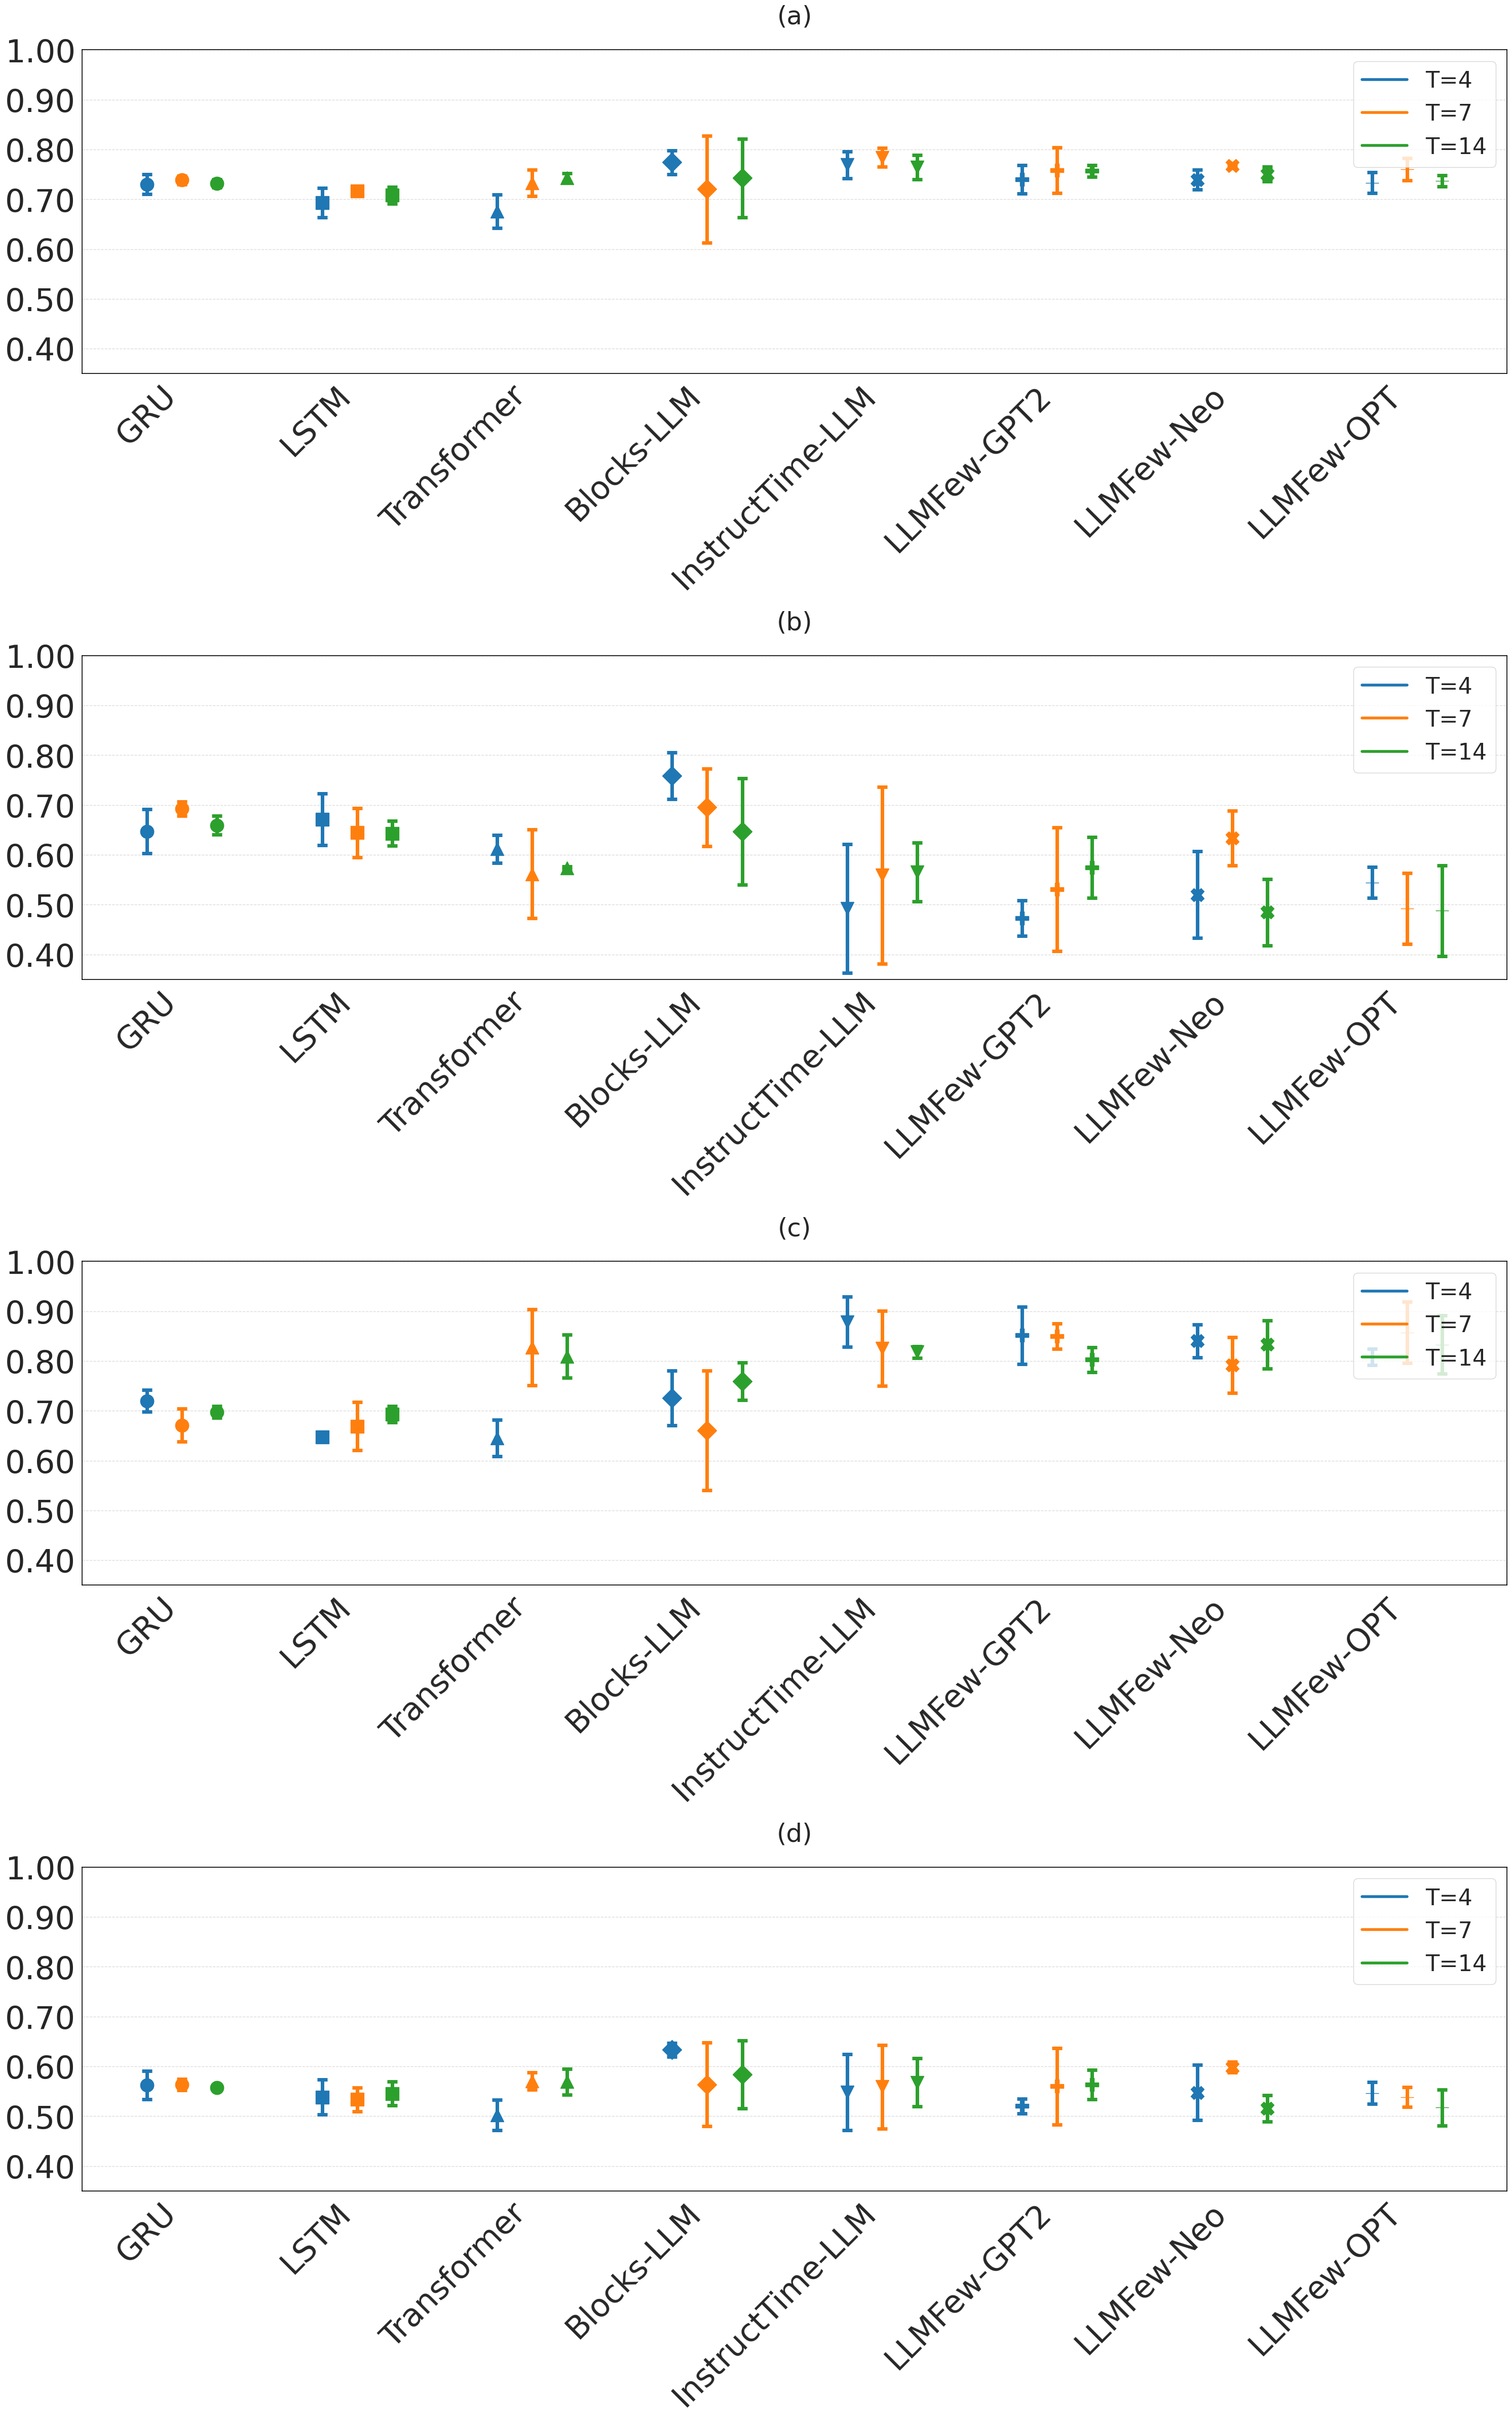

In [10]:
# List of metrics to process
import matplotlib.ticker as ticker

metrics = ['ROC AUC', 'Sensitivity', 'Specificity', 'F1 Score']

# Function to process all metrics for a given DataFrame, method name, and window size
def process_all_metrics(df, method_name, window):
    summary_list = []
    for metric in metrics:
        mean_val = df[metric].mean()  # Calculate mean of the metric
        std_val = df[metric].std()    # Calculate standard deviation of the metric
        summary_list.append({
            'Method': method_name,
            'Window': window,
            'Metric': metric,
            'mean': mean_val,
            'std': std_val
        })
    return pd.DataFrame(summary_list)

# Dictionary containing file paths for different methods and window sizes
sources = {
    'GRU': {'W4': './Results_GRU_optuna4/metrics_GRU.csv',
            'W7': './Results_GRU_optuna7/metrics_GRU.csv',
            'W14': './Results_GRU_optuna14/metrics_GRU.csv'},
    'LSTM': {'W4': './Results_LSTM_optuna4/metrics_LSTM.csv',
             'W7': './Results_LSTM_optuna7/metrics_LSTM.csv',
             'W14': './Results_LSTM_optuna14/metrics_LSTM.csv'},
    'Transformer': {'W4': './Results_Transformer_optuna4/metrics_Transformer.csv',
                    'W7': './Results_Transformer_optuna7/metrics_Transformer.csv',
                    'W14': './Results_Transformer_optuna14/metrics_Transformer.csv'},
    'Blocks-LLM': {'W4': './Results_GPT24/metrics_GPT2.csv',
                   'W7': './Results_GPT27/metrics_GPT2.csv',
                   'W14': './Results_GPT214/metrics_GPT2.csv'},
    'InstructTime-LLM': {'W4': './Results_InstructTimeLlama4/metrics_InstructTimeLlama.csv',
                      'W7': './Results_InstructTimeLlama7/metrics_InstructTimeLlama.csv',
                      'W14': './Results_InstructTimeLlama14/metrics_InstructTimeLlama.csv'},
    'LLMFew-GPT2': {'W4': './Results_FewPGT24/metrics_FewGPT2.csv',
                     'W7': './Results_FewPGT27/metrics_FewGPT2.csv',
                     'W14': './Results_FewPGT214/metrics_FewGPT2.csv'},
    'LLMFew-Neo': {'W4': './Results_FewNeo4/metrics_FewNeo.csv',
                    'W7': './Results_FewNeo7/metrics_FewNeo.csv',
                    'W14': './Results_FewNeo14/metrics_FewNeo.csv'},
    'LLMFew-OPT': {'W4': './Results_FewOpt4/metrics_FewOpt.csv',
                    'W7': './Results_FewOpt7/metrics_FewOpt.csv',
                    'W14': './Results_FewOpt14/metrics_FewOpt.csv'}
}

# Processing all metrics from the sources
all_data = pd.DataFrame()
for method, windows in sources.items():
    for window, path in windows.items():
        df = pd.read_csv(path)
        summary_df = process_all_metrics(df, method, window)
        all_data = pd.concat([all_data, summary_df], ignore_index=True)

# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 1, figsize=(30, 48))  
methods = list(sources.keys())
windows = ['W4', 'W7', 'W14']
window_labels = ['T=4', 'T=7', 'T=14']
colors = sns.color_palette('tab10', len(windows))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '+']
x_positions = np.arange(len(methods))
width = 0.2
axes = axes.flatten()

# Iterate through each metric and create a subplot
# Iterate through each metric and create a subplot
for ax_idx, metric in enumerate(metrics):
    ax = axes[ax_idx]
    
    xtick_labels = methods

    for idx, method in enumerate(methods):
        for win_idx, window in enumerate(windows):
            method_data = all_data[
                (all_data['Method'] == method) & 
                (all_data['Window'] == window) & 
                (all_data['Metric'] == metric)
            ]
            x = x_positions[idx] + (win_idx - 1) * width
            y = method_data['mean'].values[0]
            yerr = method_data['std'].values[0]
            marker = markers[idx % len(markers)]
            ax.errorbar(x, y, yerr=yerr, marker=marker, color=colors[win_idx], linestyle='',
                        markersize=19, capsize=7, elinewidth=5, capthick=5)

    # Add subplot labels
    ax.text(0.5, 1.08, f'({chr(97 + ax_idx)})', fontsize=36, ha='center', transform=ax.transAxes)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(xtick_labels, fontsize=45, rotation=45, ha='right')  # <- Aquí usamos los labels modificados
    ax.tick_params(axis='y', labelsize=45)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_ylim(0.35, 1.00)
    ax.set_yticks(np.arange(0.4, 1.05, 0.10))  
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(False)

    # Create legend
    handles = [plt.Line2D([], [], linestyle='-', color=colors[i], linewidth=4, label=window_labels[i])
               for i in range(len(windows))]
    ax.legend(handles=handles, loc='upper right', fontsize=32, frameon=True)

    # Style plot borders
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)


# Final adjustments and save the plot
plt.tight_layout()
plt.savefig('metrics_comparison_subplots.pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)
plt.show()

In [6]:
# Function to calculate the mean and std of all metrics
def calculate_overall_mean_and_std(df, model_name, window):
    # Calculate the mean and standard deviation of the metrics
    roc_auc_mean = df['ROC AUC'].mean()
    roc_auc_std = df['ROC AUC'].std()
    
    sensitivity_mean = df['Sensitivity'].mean()
    sensitivity_std = df['Sensitivity'].std()
    
    specificity_mean = df['Specificity'].mean()
    specificity_std = df['Specificity'].std()
    
    f1_score_mean = df['F1 Score'].mean()
    f1_score_std = df['F1 Score'].std()
    
    # Return the results as a DataFrame
    return pd.DataFrame({
        'Model': [model_name],
        'Window': [window],
        'ROC AUC mean': [roc_auc_mean],
        'ROC AUC std': [roc_auc_std],
        'Sensitivity mean': [sensitivity_mean],
        'Sensitivity std': [sensitivity_std],
        'Specificity mean': [specificity_mean],
        'Specificity std': [specificity_std],
        'F1 Score mean': [f1_score_mean],
        'F1 Score std': [f1_score_std]
    })

# Paths organized by model and window
sources = {
    'GRU': {'W4': './Results_GRU_optuna4/metrics_GRU.csv',
            'W7': './Results_GRU_optuna7/metrics_GRU.csv',
            'W14': './Results_GRU_optuna14/metrics_GRU.csv'},
    'LSTM': {'W4': './Results_LSTM_optuna4/metrics_LSTM.csv',
             'W7': './Results_LSTM_optuna7/metrics_LSTM.csv',
             'W14': './Results_LSTM_optuna14/metrics_LSTM.csv'},
    'Transformer': {'W4': './Results_Transformer_optuna4/metrics_Transformer.csv',
                    'W7': './Results_Transformer_optuna7/metrics_Transformer.csv',
                    'W14': './Results_Transformer_optuna14/metrics_Transformer.csv'},
    'BLOCKS-LLM': {'W4': './Results_GPT24/metrics_GPT2.csv',
                   'W7': './Results_GPT27/metrics_GPT2.csv',
                   'W14': './Results_GPT214/metrics_GPT2.csv'},
    'INSTRUCT-TIME': {'W4': './Results_InstructTimeLlama4/metrics_InstructTimeLlama.csv',
                      'W7': './Results_InstructTimeLlama7/metrics_InstructTimeLlama.csv',
                      'W14': './Results_InstructTimeLlama14/metrics_InstructTimeLlama.csv'},
    'LLM-FEW GPT2': {'W4': './Results_FewPGT24/metrics_FewGPT2.csv',
                     'W7': './Results_FewPGT27/metrics_FewGPT2.csv',
                     'W14': './Results_FewPGT214/metrics_FewGPT2.csv'},
    'LLM-FEW NEO': {'W4': './Results_FewNeo4/metrics_FewNeo.csv',
                    'W7': './Results_FewNeo7/metrics_FewNeo.csv',
                    'W14': './Results_FewNeo14/metrics_FewNeo.csv'},
    'LLM-FEW OPT': {'W4': './Results_FewOpt4/metrics_FewOpt.csv',
                    'W7': './Results_FewOpt7/metrics_FewOpt.csv',
                    'W14': './Results_FewOpt14/metrics_FewOpt.csv'}
}

# Processing all data
overall_stats_all_models = pd.DataFrame()

for model, windows in sources.items():
    for window, path in windows.items():
        df = pd.read_csv(path)
        stats_df = calculate_overall_mean_and_std(df, model, window)
        overall_stats_all_models = pd.concat([overall_stats_all_models, stats_df], ignore_index=True)

# Show the results
print(overall_stats_all_models)


            Model Window  ROC AUC mean  ROC AUC std  Sensitivity mean  \
0             GRU     W4      0.730199     0.019683          0.647115   
1             GRU     W7      0.738542     0.008521          0.692556   
2             GRU    W14      0.731549     0.008149          0.659321   
3            LSTM     W4      0.693049     0.029252          0.671156   
4            LSTM     W7      0.716063     0.007041          0.644548   
5            LSTM    W14      0.707924     0.016604          0.643109   
6     Transformer     W4      0.675755     0.033201          0.611887   
7     Transformer     W7      0.732677     0.026369          0.561804   
8     Transformer    W14      0.743145     0.008819          0.573598   
9      BLOCKS-LLM     W4      0.774060     0.024109          0.758295   
10     BLOCKS-LLM     W7      0.720340     0.107197          0.695210   
11     BLOCKS-LLM    W14      0.742609     0.078958          0.646590   
12  INSTRUCT-TIME     W4      0.768880     0.027072